In [1]:
%matplotlib inline

In [2]:
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp_sparse
import tables
import seaborn as sns
from collections import defaultdict
from __future__ import division
from scipy.stats import poisson

In [3]:
np.random.seed(0)

GeneBCMatrix = collections.namedtuple('GeneBCMatrix', ['gene_ids', 'gene_names', 'barcodes', 'matrix'])
def get_matrix_from_h5(filename, genome):
    with tables.open_file(filename, 'r') as f:
        try:
            dsets = {}
            for node in f.walk_nodes('/' + genome, 'Array'):
                dsets[node.name] = node.read()
            matrix = sp_sparse.csc_matrix((dsets['data'], dsets['indices'], dsets['indptr']), shape=dsets['shape'])
            return GeneBCMatrix(dsets['genes'], dsets['gene_names'], dsets['barcodes'], matrix)
        except tables.NoSuchNodeError:
            raise Exception("Genome %s does not exist in this file." % genome)
        except KeyError:
            raise Exception("File is missing one or more required datasets.")

def Read10x(filepath):   
    with tables.open_file(filepath, 'r') as f:
        try:
            group = f.get_node(f.root)
        except tables.NoSuchNodeError:
            print "That genome does not exist in this file."
        gene_ids = getattr(group, 'gene_ids').read()
        gene_names = getattr(group, 'gene_names').read()
        gene = getattr(group, 'gene').read()
        umi_corrected_reads=getattr(group, 'umi_corrected_reads').read()
        nonconf_mapped_reads=getattr(group, 'nonconf_mapped_reads').read()
        conf_mapped_uniq_read_pos=getattr(group, 'conf_mapped_uniq_read_pos').read()
        unmapped_reads=getattr(group, 'unmapped_reads').read()
        barcodes = getattr(group, 'barcode').read()
        reads = getattr(group, 'reads').read()
        umi = getattr(group, 'umi').read()

        TABLE=pd.DataFrame()
        TABLE['bc']=barcodes
        TABLE['umi']=umi
        #TABLE['bcumi']=zip(barcodes,umi)
        TABLE['gene']=gene
        TABLE['unique']=[1]*len(TABLE)
        TABLE['map_logical']=conf_mapped_uniq_read_pos>0
        TABLE['read_counts']=reads+nonconf_mapped_reads+unmapped_reads
        return TABLE
def setenv(newDict):
    DNA={}
    DNA['A']='00'
    DNA['C']='01'
    DNA['G']='10'
    DNA['T']='11'

    BC_DNA2={}
    for i in newDict.iterkeys(): 
        string=newDict[i]
        for j in DNA.iterkeys():
            string=string.replace(j,DNA[j])
        BC_DNA2[i]=int(string,2)
    return BC_DNA2
def get_gene(BC,df_1):
    Total=df_1.gene[df_1.bc==BC].value_counts().to_frame()
    Total.columns=['Counts']
    genes1=np.zeros(32739)
    for index,rows in Total.iterrows():
        genes1[index]=rows['Counts']
    return sp_sparse.csr_matrix(genes1[:-1])

In [4]:
newDict = {}
#insert path to barcode text file
with open('/../enriched_barcodes.txt', 'r') as f:
    for line in f:
        splitLine = line.split(',')
        newDict[int(splitLine[0])] = splitLine[1][:-1]
BC=setenv(newDict)

In [5]:
BC

{0: 2447304164,
 1: 1831374431,
 2: 2777602941,
 3: 4069560727,
 4: 3159016981,
 5: 1237536813,
 6: 3442027070,
 7: 878895426,
 8: 2876950998,
 9: 2641437145,
 10: 782271600,
 11: 425949806,
 12: 74404242,
 13: 4148209948,
 14: 457224588,
 15: 2337869073,
 16: 307804185,
 17: 2902003449,
 18: 3526922860,
 19: 1644725441,
 20: 1897320229,
 21: 2037426491,
 22: 3011316760,
 23: 2902014267,
 24: 1553767297,
 25: 3365849057,
 26: 2045589819,
 27: 446614033,
 30: 4150073440,
 31: 3842204791,
 32: 3526959403,
 33: 4115206434,
 34: 1553952741,
 35: 425949806,
 36: 3089673788,
 37: 1231069479,
 38: 2935154170,
 39: 2403930468,
 40: 3553024695,
 41: 878892926,
 42: 2232204505,
 43: 1372026117,
 44: 651120533,
 45: 2676013090,
 46: 1723033910,
 47: 550165679,
 48: 1152598806,
 49: 3496174711,
 50: 1372026664,
 51: 3711101787,
 52: 1671738673,
 53: 3089698441,
 54: 3077345579,
 55: 2465246051,
 56: 2827815325,
 57: 2800520619,
 58: 2484030295,
 59: 1897320600,
 60: 94068970,
 61: 3331277687,
 62:

In [6]:
#insert path to non enriched deep sequencing molecule info H5 file from 10X pipeline
c_path='/../molecule_info.h5'
control=Read10x(c_path)

In [7]:
#HLA_DR
filtered_matrix_h5='/Users/nranu/Desktop/SC_enrichment/filtered_gene_bc_matrices_h5.h5'

genome = "hg19"

%time gene_bc_matrix = get_matrix_from_h5(filtered_matrix_h5, genome)

gnames=gene_bc_matrix.gene_names
cnames=gene_bc_matrix.barcodes
DGE=pd.DataFrame(gene_bc_matrix.matrix.toarray())
DGE.index=gnames
DGE.columns=cnames

CPU times: user 137 ms, sys: 176 ms, total: 314 ms
Wall time: 2.34 s


In [8]:
umi=pd.DataFrame(control.bc.value_counts())
umi.columns=['Umi']

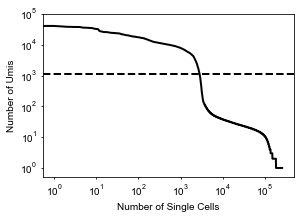

In [9]:
fig, ax = plt.subplots(figsize=(4.5,3))
sns.set(style='white')
sns.set_context("paper",rc={"lines.linewidth": 2,'axes.labelsize': 16,'text.fontsize': 12,'legend.fontsize': 12,
   'xtick.labelsize': 12,'ytick.labelsize': 12,'text.usetex': False})
plt.plot(range(0,umi.shape[0]),umi.Umi,c='k')
plt.xlabel('Number of Single Cells')
plt.ylabel('Number of Umis')

plt.yscale('log')
plt.xscale('log')
plt.axhline(y=1100,color='k',ls='dashed')
ax.tick_params(axis=u'both', which=u'both',length=2)
plt.minorticks_off()
plt.ylim([.5,100000])
sns.set_context("paper",rc={"lines.linewidth": 2,'axes.labelsize': 10,'text.fontsize': 10,'legend.fontsize': 10,
   'xtick.labelsize': 10,'ytick.labelsize': 10,'text.usetex': False})


In [16]:
rare=defaultdict(str)
counter=0
for bc_ in DGE.columns:
    rare[counter]=bc_[:-2]
    counter+=1
BC_set=setenv(rare)

In [46]:
samples=[1,2,3]
t_path=#Path to data
sample_path1='NR_'+str(samples[0])+'/'
sample_path2='NR_'+str(samples[1])+'/'
sample_path3='NR_'+str(samples[2])+'/'
file_path='molecule_info.h5'
filtered_matrix_h5='/Users/nranu/Desktop/SC_enrichment/filtered_gene_bc_matrices_h5.h5'
genome = "hg19"
#%time gene_bc_matrix1 = get_matrix_from_h5(t_path+sample_path1+file_path, genome)
#%time gene_bc_matrix2 = get_matrix_from_h5(t_path+sample_path2+file_path, genome)
#%time gene_bc_matrix3 = get_matrix_from_h5(t_path+sample_path3+file_path, genome)
NR1=Read10x(t_path+sample_path1+file_path)
NR2=Read10x(t_path+sample_path2+file_path)
NR3=Read10x(t_path+sample_path3+file_path)

In [47]:
samples=[16,17,18]
t_path=#Path to data
sample_path1='NR_'+str(samples[0])+'/'
sample_path2='NR_'+str(samples[1])+'/'
sample_path3='NR_'+str(samples[2])+'/'
file_path='molecule_info.h5'
filtered_matrix_h5='/Users/nranu/Desktop/SC_enrichment/filtered_gene_bc_matrices_h5.h5'
genome = "hg19"
#%time gene_bc_matrix16 = get_matrix_from_h5(t_path+sample_path1+file_path, genome)
#%time gene_bc_matrix17= get_matrix_from_h5(t_path+sample_path2+file_path, genome)
#%time gene_bc_matrix18 = get_matrix_from_h5(t_path+sample_path3+file_path, genome)
NR16=Read10x(t_path+sample_path1+file_path)
NR17=Read10x(t_path+sample_path2+file_path)
NR18=Read10x(t_path+sample_path3+file_path)

In [94]:
samples=[1,2,3]
t_path=#Path to data
sample_path1='NR_'+str(samples[0])+'/'
sample_path2='NR_'+str(samples[1])+'/'
sample_path3='NR_'+str(samples[2])+'/'
file_path='molecule_info.h5'
filtered_matrix_h5='/Users/nranu/Desktop/SC_enrichment/filtered_gene_bc_matrices_h5.h5'
genome = "hg19"
#%time gene_bc_matrix16 = get_matrix_from_h5(t_path+sample_path1+file_path, genome)
#%time gene_bc_matrix17= get_matrix_from_h5(t_path+sample_path2+file_path, genome)
#%time gene_bc_matrix18 = get_matrix_from_h5(t_path+sample_path3+file_path, genome)
NR1_1=Read10x(t_path+sample_path1+file_path)
NR2_1=Read10x(t_path+sample_path2+file_path)
NR3_1=Read10x(t_path+sample_path3+file_path)

In [95]:
samples=[1,2,3]
t_path=#Path to data
sample_path1='NR_'+str(samples[0])+'/'
sample_path2='NR_'+str(samples[1])+'/'
sample_path3='NR_'+str(samples[2])+'/'
file_path='molecule_info.h5'
#filtered_matrix_h5='/Users/nranu/Desktop/SC_enrichment/filtered_gene_bc_matrices_h5.h5'
#genome = "hg19"
#%time gene_bc_matrix16 = get_matrix_from_h5(t_path+sample_path1+file_path, genome)
#%time gene_bc_matrix17= get_matrix_from_h5(t_path+sample_path2+file_path, genome)
#%time gene_bc_matrix18 = get_matrix_from_h5(t_path+sample_path3+file_path, genome)
NR1_2=Read10x(t_path+sample_path1+file_path)
NR2_2=Read10x(t_path+sample_path2+file_path)
NR3_2=Read10x(t_path+sample_path3+file_path)

In [96]:
samples=[4,5,6]
t_path=#Path to data
sample_path1='NR_'+str(samples[0])+'/'
sample_path2='NR_'+str(samples[1])+'/'
sample_path3='NR_'+str(samples[2])+'/'
file_path='molecule_info.h5'
#filtered_matrix_h5='/Users/nranu/Desktop/SC_enrichment/filtered_gene_bc_matrices_h5.h5'
#genome = "hg19"
#%time gene_bc_matrix16 = get_matrix_from_h5(t_path+sample_path1+file_path, genome)
#%time gene_bc_matrix17= get_matrix_from_h5(t_path+sample_path2+file_path, genome)
#%time gene_bc_matrix18 = get_matrix_from_h5(t_path+sample_path3+file_path, genome)
NR4=Read10x(t_path+sample_path1+file_path)
NR5=Read10x(t_path+sample_path2+file_path)
NR6=Read10x(t_path+sample_path3+file_path)

In [175]:
print NR1_1.read_counts.sum(),NR2_1.read_counts.sum(),NR3_1.read_counts.sum()

1199414 1300097 1443786


In [177]:
np.mean([1199414,1443786,1300097])

1314432.3333333333

In [49]:
S_NR1=NR1.sample(1000000,weights=NR1.read_counts,replace=True)
S_NR2=NR2.sample(1000000,weights=NR2.read_counts,replace=True)
S_NR3=NR3.sample(1000000,weights=NR3.read_counts,replace=True)
S_C=control.sample(1000000,weights=control.read_counts,replace=True)

In [50]:
S_NR16=NR16.sample(880000,weights=NR16.read_counts,replace=True)
S_NR17=NR17.sample(880000,weights=NR17.read_counts,replace=True)
S_NR18=NR18.sample(880000,weights=NR18.read_counts,replace=True)
S_C_2=control.sample(880000,weights=control.read_counts,replace=True)

In [135]:
S_NR1_1=NR1_1.sample(1000000,weights=NR1_1.read_counts,replace=True)
S_NR2_1=NR2_1.sample(1000000,weights=NR2_1.read_counts,replace=True)
S_NR3_1=NR3_1.sample(1000000,weights=NR3_1.read_counts,replace=True)
S_C_3=control.sample(1000000,weights=control.read_counts,replace=True)

In [136]:
S_NR1_2=NR1_2.sample(2600000,weights=NR1_2.read_counts,replace=True)
S_NR2_2=NR2_2.sample(2600000,weights=NR2_2.read_counts,replace=True)
S_NR3_2=NR3_2.sample(2600000,weights=NR3_2.read_counts,replace=True)
S_C_4=control.sample(2600000,weights=control.read_counts,replace=True)

In [137]:
S_NR4=NR4.sample(2900000,weights=NR4.read_counts,replace=True)
S_NR5=NR5.sample(2900000,weights=NR5.read_counts,replace=True)
S_NR6=NR6.sample(2900000,weights=NR6.read_counts,replace=True)
S_C_5=control.sample(2900000,weights=control.read_counts,replace=True)

In [52]:
umi_=defaultdict(int)
for k,val in BC_set.iteritems():
    #val=BC[item]
    a=len(S_NR1[(S_NR1.bc==val)&(S_NR1.read_counts>2)]['umi'].unique())
    b=len(S_NR2[(S_NR2.bc==val)&(S_NR2.read_counts>2)]['umi'].unique())
    c=len(S_NR3[(S_NR3.bc==val)&(S_NR3.read_counts>2)]['umi'].unique())
    d=len(S_C[S_C.bc==val]['umi'].unique())
    umi_[val]=[a,b,c,d]

In [53]:
umi_2=defaultdict(int)
for k,val in BC_set.iteritems():
    #val=BC[item]
    a=len(S_NR16[(S_NR16.bc==val)&(S_NR16.read_counts>2)]['umi'].unique())
    b=len(S_NR17[(S_NR17.bc==val)&(S_NR17.read_counts>2)]['umi'].unique())
    c=len(S_NR18[(S_NR18.bc==val)&(S_NR18.read_counts>2)]['umi'].unique())
    d=len(S_C_2[S_C_2.bc==val]['umi'].unique())
    umi_2[val]=[a,b,c,d]

In [105]:
umi_3=defaultdict(int)
for k,val in BC_set.iteritems():
    #val=BC[item]
    a=len(S_NR1_1[(S_NR1_1.bc==val)&(S_NR1_1.read_counts>2)]['umi'].unique())
    b=len(S_NR2_1[(S_NR2_1.bc==val)&(S_NR2_1.read_counts>2)]['umi'].unique())
    c=len(S_NR3_1[(S_NR3_1.bc==val)&(S_NR3_1.read_counts>2)]['umi'].unique())
    d=len(S_C_3[S_C_3.bc==val]['umi'].unique())
    umi_3[val]=[a,b,c,d]

In [138]:
umi_4=defaultdict(int)
for k,val in BC_set.iteritems():
    #val=BC[item]
    a=len(S_NR1_2[(S_NR1_2.bc==val)&(S_NR1_2.read_counts>2)]['umi'].unique())
    b=len(S_NR2_2[(S_NR2_2.bc==val)&(S_NR2_2.read_counts>2)]['umi'].unique())
    c=len(S_NR3_2[(S_NR3_2.bc==val)&(S_NR3_2.read_counts>2)]['umi'].unique())
    d=len(S_C_3[S_C_3.bc==val]['umi'].unique())
    umi_4[val]=[a,b,c,d]

In [139]:
umi_5=defaultdict(int)
for k,val in BC_set.iteritems():
    #val=BC[item]
    a=len(S_NR4[(S_NR4.bc==val)&(S_NR4.read_counts>2)]['umi'].unique())
    b=len(S_NR5[(S_NR5.bc==val)&(S_NR5.read_counts>2)]['umi'].unique())
    c=len(S_NR6[(S_NR6.bc==val)&(S_NR6.read_counts>2)]['umi'].unique())
    d=len(S_C_3[S_C_3.bc==val]['umi'].unique())
    umi_5[val]=[a,b,c,d]

In [55]:
umi_df=pd.DataFrame.from_dict(umi_,orient='index')
umi_df.columns=['rep1','rep2','rep3','control']
umi_df['ave']=umi_df[['rep1','rep2','rep3']].mean(axis=1)
umi_df['fold']=umi_df.ave/umi_df.control

In [56]:
umi_df_2=pd.DataFrame.from_dict(umi_2,orient='index')
umi_df_2.columns=['rep1','rep2','rep3','control']
umi_df_2['ave']=umi_df_2[['rep1','rep2','rep3']].mean(axis=1)
umi_df_2['fold']=umi_df_2.ave/umi_df_2.control

In [57]:
umi_df_3=pd.DataFrame.from_dict(umi_3,orient='index')
umi_df_3.columns=['rep1','rep2','rep3','control']
umi_df_3['ave']=umi_df_3[['rep1','rep2','rep3']].mean(axis=1)
umi_df_3['fold']=umi_df_3.ave/umi_df_3.control

In [140]:
umi_df_4=pd.DataFrame.from_dict(umi_4,orient='index')
umi_df_4.columns=['rep1','rep2','rep3','control']
umi_df_4['ave']=umi_df_4[['rep1','rep2','rep3']].mean(axis=1)
umi_df_4['fold']=umi_df_4.ave/umi_df_4.control

In [141]:
umi_df_5=pd.DataFrame.from_dict(umi_5,orient='index')
umi_df_5.columns=['rep1','rep2','rep3','control']
umi_df_5['ave']=umi_df_5[['rep1','rep2','rep3']].mean(axis=1)
umi_df_5['fold']=umi_df_5.ave/umi_df_5.control

In [157]:
umi_df['Keep']=0
umi_df_2['Keep']=0
umi_df_3['Keep']=0

umi_df_4['Keep']=0
umi_df_5['Keep']=0

In [59]:
umi_df['rep1_']=umi_df_2.rep1/umi_df_2.control
umi_df['rep2_']=umi_df_2.rep2/umi_df_2.control
umi_df['rep3_']=umi_df_2.rep3/umi_df_2.control

In [60]:
umi_df_2['rep1_']=umi_df_2.rep1/umi_df_2.control
umi_df_2['rep2_']=umi_df_2.rep2/umi_df_2.control
umi_df_2['rep3_']=umi_df_2.rep3/umi_df_2.control

In [61]:
umi_df_3['rep1_']=umi_df_3.rep1/umi_df_3.control
umi_df_3['rep2_']=umi_df_3.rep2/umi_df_3.control
umi_df_3['rep3_']=umi_df_3.rep3/umi_df_3.control

In [143]:
umi_df_4['rep1_']=umi_df_4.rep1/umi_df_4.control
umi_df_4['rep2_']=umi_df_4.rep2/umi_df_4.control
umi_df_4['rep3_']=umi_df_4.rep3/umi_df_4.control

In [144]:
umi_df_5['rep1_']=umi_df_5.rep1/umi_df_5.control
umi_df_5['rep2_']=umi_df_5.rep2/umi_df_5.control
umi_df_5['rep3_']=umi_df_5.rep3/umi_df_5.control

In [145]:
umi_df['std']=umi_df[['rep1_','rep2_','rep3_']].std(axis=1)
umi_df_2['std']=umi_df_2[['rep1_','rep2_','rep3_']].std(axis=1)
umi_df_3['std']=umi_df_3[['rep1_','rep2_','rep3_']].std(axis=1)
umi_df_4['std']=umi_df_4[['rep1_','rep2_','rep3_']].std(axis=1)
umi_df_5['std']=umi_df_5[['rep1_','rep2_','rep3_']].std(axis=1)

In [158]:
list_a=[0,1,2,3,4,5,6,7,8,9]
list_b=[12,13,14,15,16,17,30,31,32,33]
list_c=[34,35,37,38,39,40,41,42,43]
list_d=[44,45,46,48,49,50,51,52,53]
list_e=[54,55,56,58,59,60,61,62,63,64,65,68]

list_f2=[4,5,6,7,8,9,12,13,14,15,16,17,30,31,32,33,34,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,58,59,60,61,62,63,64,65,68]
for a in list_a:
    umi_df.set_value(BC[a],'Keep',1)
for b in list_b:
    umi_df_2.set_value(BC[b],'Keep',1)
for c in list_c:
    umi_df_3.set_value(BC[c],'Keep',1)
for d in list_d:
    umi_df_4.set_value(BC[d],'Keep',1)
for e in list_e:
    umi_df_5.set_value(BC[e],'Keep',1)

/Users/nranu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/Users/nranu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
/Users/nranu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
/Users/nranu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app
/Users/nranu/anaconda2/lib/python2.7/site-packa

In [147]:
umi_df['umi']=0
umi_df_2['umi']=0
umi_df_3['umi']=0
umi_df_4['umi']=0
umi_df_5['umi']=0

In [124]:
cumi2=pd.DataFrame(control.bc.value_counts())

In [148]:
for index in umi_df.index:
    umi_df.set_value(index,'umi',cumi2.loc[index].bc)
for index in umi_df_2.index:
    umi_df_2.set_value(index,'umi',cumi2.loc[index].bc)
for index in umi_df_3.index:
    umi_df_3.set_value(index,'umi',cumi2.loc[index].bc)
for index in umi_df_4.index:
    umi_df_4.set_value(index,'umi',cumi2.loc[index].bc)
for index in umi_df_5.index:
    umi_df_5.set_value(index,'umi',cumi2.loc[index].bc)

/Users/nranu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/nranu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.
/Users/nranu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/nranu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/nranu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future

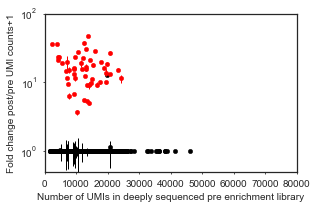

In [181]:
fig, ax = plt.subplots(figsize=(4.5,3))
sns.set(style='white')
sns.set_context("talk")
plt.xlabel('Number of UMIs in deeply sequenced pre enrichment library')
plt.ylabel('Fold change post/pre UMI counts+1')
plt.scatter(umi_df[umi_df.Keep==0]['umi'],umi_df[umi_df.Keep==0]['fold']+1,c='k',s=20)

plt.scatter(umi_df[umi_df.Keep==1]['umi'],umi_df[umi_df.Keep==1]['fold']+1,c='r',s=20)
plt.scatter(umi_df_2[umi_df_2.Keep==1]['umi'],umi_df_2[umi_df_2.Keep==1]['fold']+1,c='r',s=20)
plt.scatter(umi_df_3[umi_df_3.Keep==1]['umi'],umi_df_3[umi_df_3.Keep==1]['fold']+1,c='r',s=20)
plt.scatter(umi_df_4[umi_df_4.Keep==1]['umi'],umi_df_4[umi_df_4.Keep==1]['fold']+1,c='r',s=20)
plt.scatter(umi_df_5[umi_df_5.Keep==1]['umi'],umi_df_5[umi_df_5.Keep==1]['fold']+1,c='r',s=20)

plt.errorbar(umi_df[umi_df.Keep==0]['umi'],umi_df[umi_df.Keep==0]['fold']+1,yerr=umi_df[umi_df.Keep==0]['std'], ecolor='k',linestyle="None",capsize=2.5,lw=1)

plt.errorbar(umi_df[umi_df.Keep==1]['umi'],umi_df[umi_df.Keep==1]['fold']+1,yerr=umi_df[umi_df.Keep==1]['std'],ecolor = 'r', linestyle="None",capsize=2.5,)
plt.errorbar(umi_df_2[umi_df_2.Keep==1]['umi'],umi_df_2[umi_df_2.Keep==1]['fold']+1,yerr=umi_df_2[umi_df_2.Keep==1]['std'],ecolor = 'r', linestyle="None",capsize=2.5,lw=1)
plt.errorbar(umi_df_3[umi_df_3.Keep==1]['umi'],umi_df_3[umi_df_3.Keep==1]['fold']+1,yerr=umi_df_3[umi_df_3.Keep==1]['std'],ecolor = 'r', linestyle="None",capsize=2.5,lw=1)
plt.errorbar(umi_df_4[umi_df_4.Keep==1]['umi'],umi_df_4[umi_df_4.Keep==1]['fold']+1,yerr=umi_df_4[umi_df_4.Keep==1]['std'],ecolor = 'r', linestyle="None",capsize=2.5,lw=1)
plt.errorbar(umi_df_5[umi_df_5.Keep==1]['umi'],umi_df_5[umi_df_5.Keep==1]['fold']+1,yerr=umi_df_5[umi_df_5.Keep==1]['std'],ecolor = 'r', linestyle="None",capsize=2.5,lw=1)

plt.yscale('log')
ax.tick_params(axis=u'both', which=u'both',length=2)
plt.minorticks_off()
#plt.xscale('log')
plt.xlim([0,80000])
plt.ylim([.5,100])
sns.set_context("paper",rc={"lines.linewidth": 2,'axes.labelsize': 10,'text.fontsize': 10,'legend.fontsize': 10,
   'xtick.labelsize': 10,'ytick.labelsize': 10,'text.usetex': False})
fig.tight_layout()
plt.savefig('/Volumes/broad_blainey_lab_storage/Nav/temp/Manucript/Figures/FiguresV2/10X structure/HLA_DR_UMI_enrich.pdf',transparent=True)